# Importando dependências

In [1]:
import pandas as pd
import glob
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pandas_profiling
from pandas_profiling import ProfileReport
from folium.plugins import HeatMap
sns.set_theme(style="white", palette="pastel")
# importing module
import warnings
  
# adding entry into the specifications
# of the warnings filter.
warnings.filterwarnings('ignore')

pd.set_option("display.precision", 2)

Pandas backend loaded 1.3.4
Numpy backend loaded 1.20.3
Pyspark backend NOT loaded
Python backend loaded


### Funções de auxílio à análise

In [2]:
class Cleaning:
    def __init__(self):
        self.usecols = ['rideable_type', 'started_at', 'ended_at', 'start_station_name',  'end_station_name','start_lat', 'start_lng', 'member_casual']
        self.dates = ['started_at', 'ended_at']
        self.categorical = [ 'member_casual','rideable_type', 'start_station_name', 'end_station_name']
        self.float_data = ['start_lat', 'start_lng','end_lat','end_lng']
        
    def read(self, data):
        dataset =  pd.read_csv(data, usecols=self.usecols, parse_dates=self.dates)        
        
        # dataset['duration'] = abs(dataset['ended_at'] - dataset['started_at'])
        
        dataset['rideable_type'] = dataset['rideable_type'].str.replace('_', ' ')
        dataset[self.categorical] = dataset[self.categorical].astype('category')
        
        dataset.dropna(axis=0, inplace=True)
    
        return dataset

In [3]:
def get_season(month):
    if month >= 3 and month <=5:
        return 'spring'
    elif month >= 6 and month <=8:
        return 'summer'
    elif month >= 9 and month <=11:
        return 'fall'
    else:
        return 'winter'

In [4]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [5]:
data = Cleaning()

## Importando dois anos de análise mensais

In [6]:
path = 'C:/Users/Usuario/Desktop/Dados/trip_data/'
all_files = glob.glob(path + '*.csv')
all_files

['C:/Users/Usuario/Desktop/Dados/trip_data\\202004-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202005-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202006-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202007-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202008-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202009-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202010-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202011-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202012-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202101-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202102-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202103-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202104-divvy-tripdata.csv',
 'C:/Users/Usuario/Desktop/Dados/trip_data\\202105-divvy-tripdat

In [7]:
# Lendo e concatenando 24 datasets realativos a 2 anos 
dataframe = [data.read(filename) for filename in all_files]
df = pd.concat(dataframe, axis=0, ignore_index=True)

In [8]:
# Análise prévia do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7936958 entries, 0 to 7936957
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rideable_type       object        
 1   started_at          datetime64[ns]
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   end_station_name    object        
 5   start_lat           float64       
 6   start_lng           float64       
 7   member_casual       category      
dtypes: category(1), datetime64[ns](2), float64(2), object(3)
memory usage: 431.4+ MB


In [9]:
# amostramento randômico estratificado
N = 100000
data = df.groupby('member_casual', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

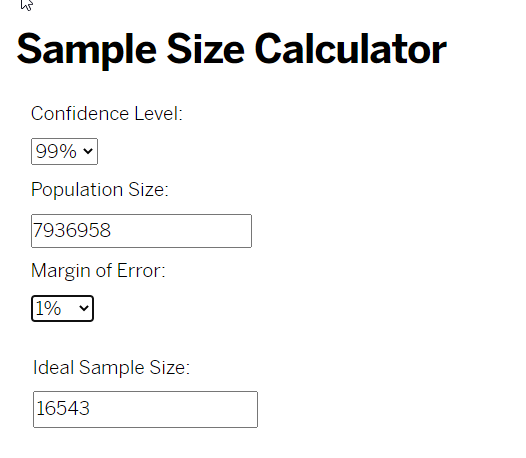

---

* Devido ao grande número de observações encontrados na completude desses dois anos de mensuração. Tomei a iniciativa de compor um amostramento estratificado randômico que representasse com fidelidade a totalidade dos dados. Com isso produzi um amostramento com **100.000** dados, muito mais que o necessário: 16543, com 99% de nível de confiança e 1% de margem de erro. O tamanho populacional foi avaliado em 7.936.958 de observações.

---

### Limpeza e transformaão dos dados

In [10]:
data['day_name'] = data.started_at.dt.day_name()
data[['rideable_type','start_station_name']] = data[['rideable_type','start_station_name']].astype('category')
data['duration'] = np.abs(data['ended_at'] - data['started_at'])
data['end_station_name'] = data['end_station_name'].astype('category')
data['day_name'] = data['day_name'].astype('category')
data = data[['rideable_type','start_lat', 'start_lng', 'started_at', 'start_station_name', 'member_casual', 'day_name', 'duration']]

In [11]:
## Limpando Outliers
# Select the first quantile
q1 = data['duration'].quantile(.05)

# Select the third quantile
q3 = data['duration'].quantile(.95)

# Create a mask inbeetween q1 & q3
mask = data['duration'].between(q1, q3)

# Filtering the initial dataframe with a mask
iqr = data.loc[mask, 'duration']
iqr = pd.DataFrame(iqr)

### Transformando dados

In [12]:
# filtrando
data = data[data.index.isin(iqr.index)]

# Criando coluna Season
data['season'] = data.started_at.dt.month

# criando coluna com valores de data somente
data['started_at'] = data['started_at'].dt.date

# Aplicando função para criação de dados categóricos
data['season'] = data['season'].apply(get_season)
data['season'] = data['season'].astype('category')

# transformando formato de dados para datetime
data.started_at = pd.to_datetime(data.started_at)

In [13]:
# traduzindo
translate = {'classic bike': 'clássica', 'docked bike':'compartilhada', 'electric bike':'elétrica', 
             'member': 'membro', 'winter': 'inverno','fall':'outono', 'summer': 'verão', 'spring': 'primavera', 
            'Friday': 'Sexta', 'Monday':'Segunda', 'Saturday': 'Sábado', 'Sunday':'Domingo', 'Thursday': 'Quinta', 
             'Tuesday': 'Terça', 'Wednesday': 'Quarta'}
data.replace(translate, inplace=True)

In [14]:
# Renomeando Colunas
data.columns = ['Tipo Bicicleta', 'Lat', 'Long', 'Início', 'Embarque', 'Usuário', 'Dia Semana', 'Duração', 'Estação do Ano']

In [15]:
# Transformando coluna em segundos
data['Duração'] = data['Duração'].dt.total_seconds()

### EDA

In [16]:
# Análise Estatística
data.describe(include='all')

,Tipo Bicicleta,Lat,Long,Início,Embarque,Usuário,Dia Semana,Duração,Estação do Ano
count,90036,90036.00,90036.00,90036,90036,90036,90036,90036.0,90036
unique,3,NaN,NaN,728,724,2,7,NaN,4
top,clássica,NaN,NaN,2021-06-05 00:00:00,Streeter Dr & Grand Ave,membro,Sábado,NaN,verão
freq,40875,NaN,NaN,368,1249,53044,16204,NaN,39383
first,NaN,NaN,NaN,2020-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
min,NaN,41.65,-87.83,NaN,NaN,NaN,NaN,180.0,NaN
25%,NaN,41.88,-87.66,NaN,NaN,NaN,NaN,464.0,NaN
50%,NaN,41.90,-87.64,NaN,NaN,NaN,NaN,781.0,NaN
75%,NaN,41.93,-87.63,NaN,NaN,NaN,NaN,1339.0,NaN


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90036 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Tipo Bicicleta  90036 non-null  object        
 1   Lat             90036 non-null  float64       
 2   Long            90036 non-null  float64       
 3   Início          90036 non-null  datetime64[ns]
 4   Embarque        90036 non-null  category      
 5   Usuário         90036 non-null  object        
 6   Dia Semana      90036 non-null  object        
 7   Duração         90036 non-null  float64       
 8   Estação do Ano  90036 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(3), object(4)
memory usage: 6.4+ MB


In [18]:
# Análise Estática usando Profile
profile = ProfileReport(data, explorative=True, dark_mode=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Visualizando dados

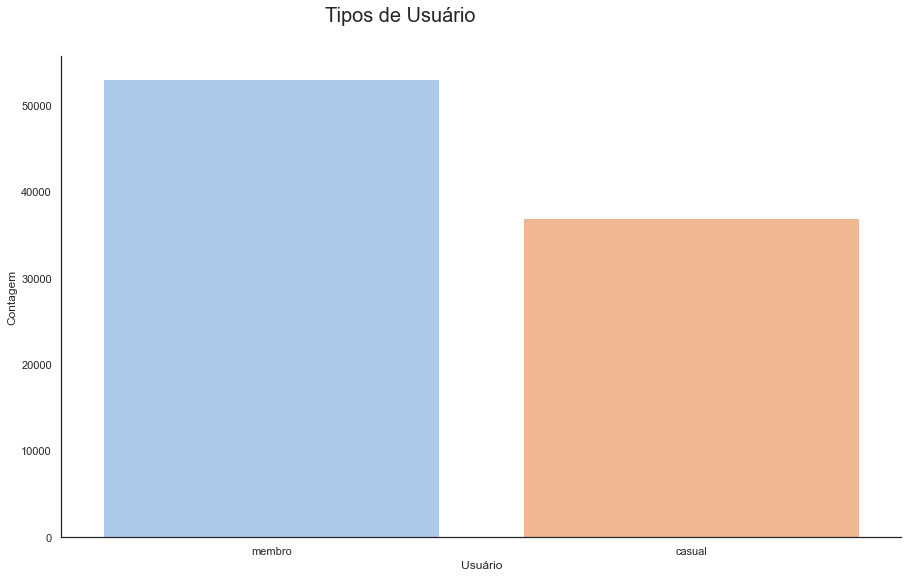

In [19]:
# Plotando os tipos de Usuário
ax = sns.catplot(x="Usuário", kind="count",  data=data);
ax.fig.suptitle('Tipos de Usuário', fontsize=20, y=1.05)
ax.set(xlabel='Usuário', ylabel='Contagem')
plt.gcf().set_size_inches(15, 8)

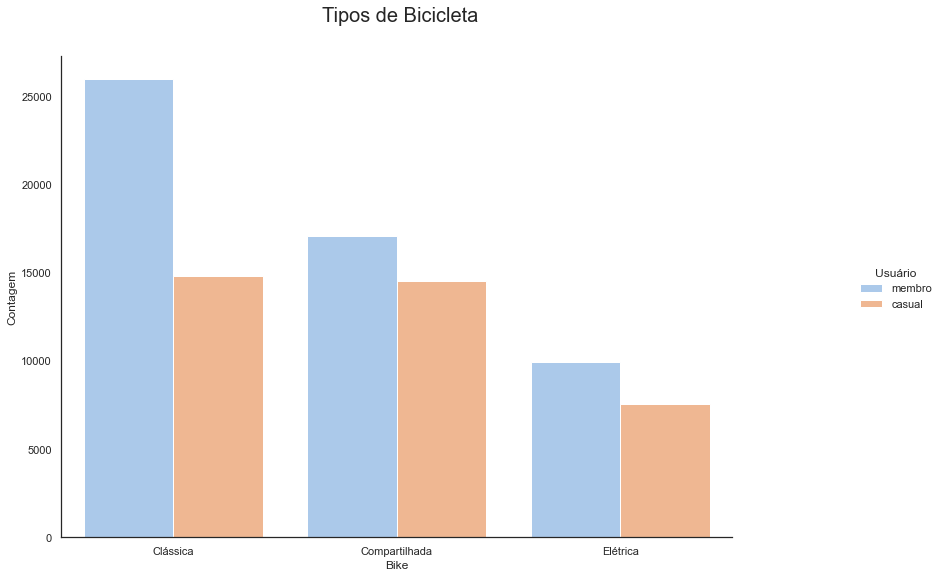

In [20]:
# Plotando dados categóricos Tipo de bicicleta por usuário
ax = sns.catplot(x="Tipo Bicicleta", kind="count",hue='Usuário',  data=data);
ax.fig.suptitle('Tipos de Bicicleta', fontsize=20, y=1.05)
ax.set_xticklabels(['Clássica', 'Compartilhada', 'Elétrica']);
ax.set(xlabel='Bike', ylabel='Contagem')
plt.gcf().set_size_inches(15, 8)

In [21]:
# Distribuição dos usuários
data['Usuário'].value_counts(normalize=True)*100

membro    58.91
casual    41.09
Name: Usuário, dtype: float64

---

* De acordo com o gráfico acima, os membros fazem mais usos de bicicleta em todos os tipos avaliados. O quê pode ser explicitado com a distribuição dos dados estratificados demonstrar que os 'membros' são **58.93%** dos dados.

---

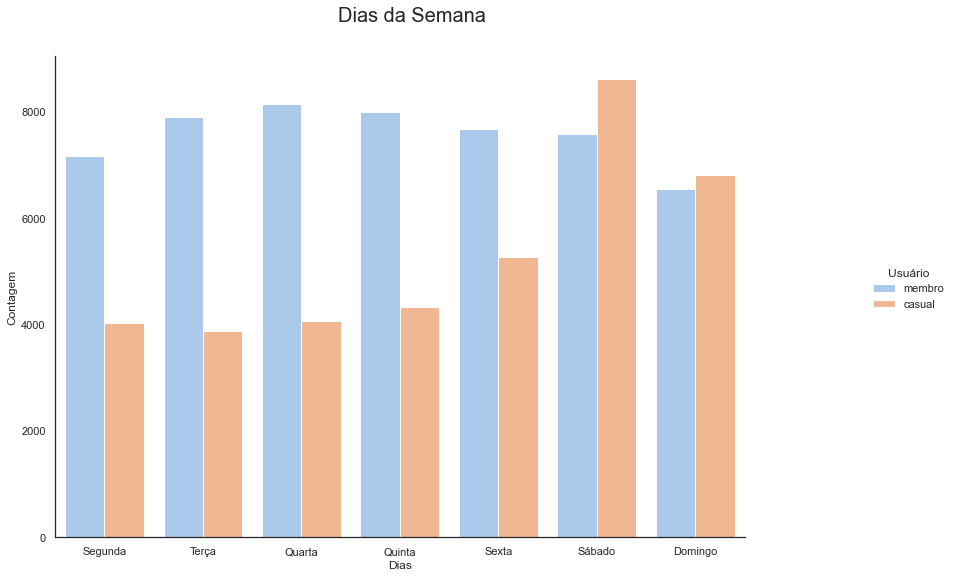

In [22]:
# Plotando a distribuição dos dados em relação aos Usuários
ax = sns.catplot(x="Dia Semana",hue='Usuário',order=['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'], kind="count",  data=data);
ax.fig.suptitle('Dias da Semana', fontsize=20, y=1.05)
ax.set(xlabel='Dias', ylabel='Contagem')
plt.gcf().set_size_inches(15, 8)

In [23]:
# fins de semana
fim_semana = ['Sexta','Sábado', 'Domingo']

In [24]:
# Membros em finais de semana
data[data['Usuário'] == 'membro']['Dia Semana'].isin(fim_semana).value_counts(normalize=True, ascending=True)*100

True     41.12
False    58.88
Name: Dia Semana, dtype: float64

In [25]:
# Casuais em finais de semana
data[data['Usuário'] == 'casual']['Dia Semana'].isin(fim_semana).value_counts(normalize=True, ascending=False)*100

True     55.95
False    44.05
Name: Dia Semana, dtype: float64

---

* A distribuição acima demonstra que os `Usuários` casuais fazem mais uso dos serviços durante os finais de semana (**55.34%** ante a **41,14%** dos membros.

---

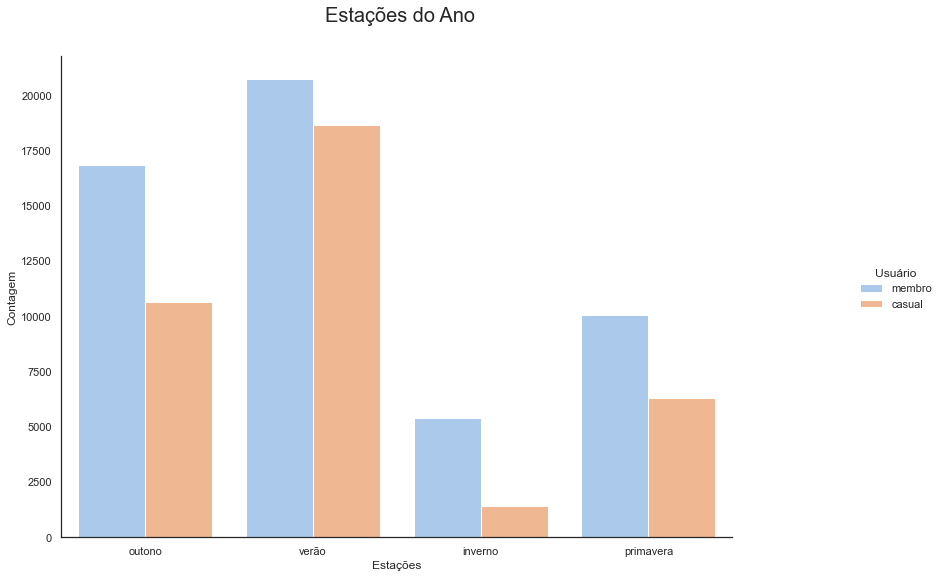

In [26]:
# Plotando a distribuição Estações do ano
ax = sns.catplot(x="Estação do Ano",hue='Usuário', kind="count",  data=data);
ax.fig.suptitle('Estações do Ano', fontsize=20, y=1.05)
ax.set(xlabel='Estações', ylabel='Contagem')
plt.gcf().set_size_inches(15, 8)

---

* Diante do gráfico acima, conclui-se que dentro dos dois anos de análise. Verão é a estação de predição dos dois tipos de usuário, seguido do outono.

---

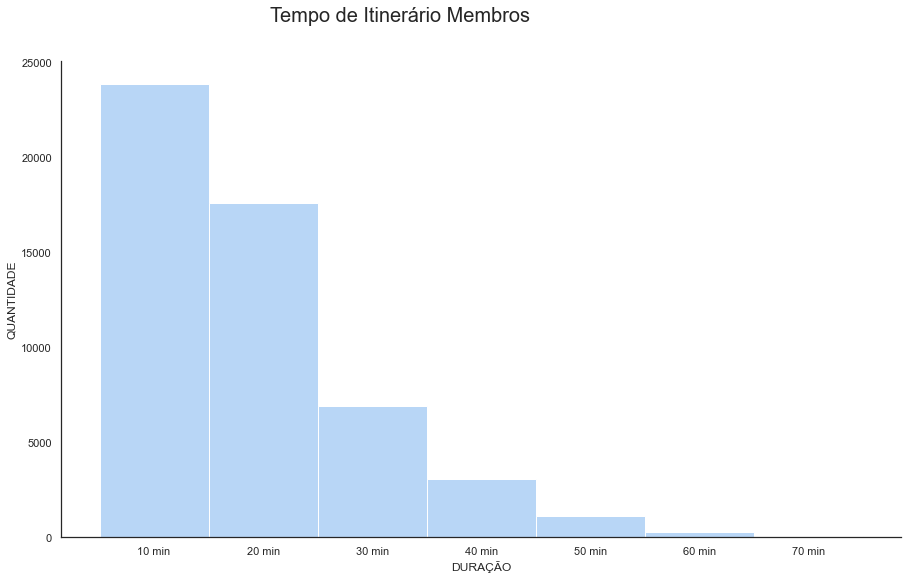

In [27]:
label = ['10 min','20 min', '30 min', '40 min', '50 min', '60 min', '70 min']
ax =sns.displot(pd.cut(data.query("Usuário == 'membro'")['Duração'], bins=np.arange(0, 4201, 600), labels=label));
ax.fig.suptitle('Tempo de Itinerário Membros', fontsize=20, y=1.05);
ax.set(xlabel='DURAÇÃO', ylabel='QUANTIDADE')
plt.gcf().set_size_inches(15, 8)

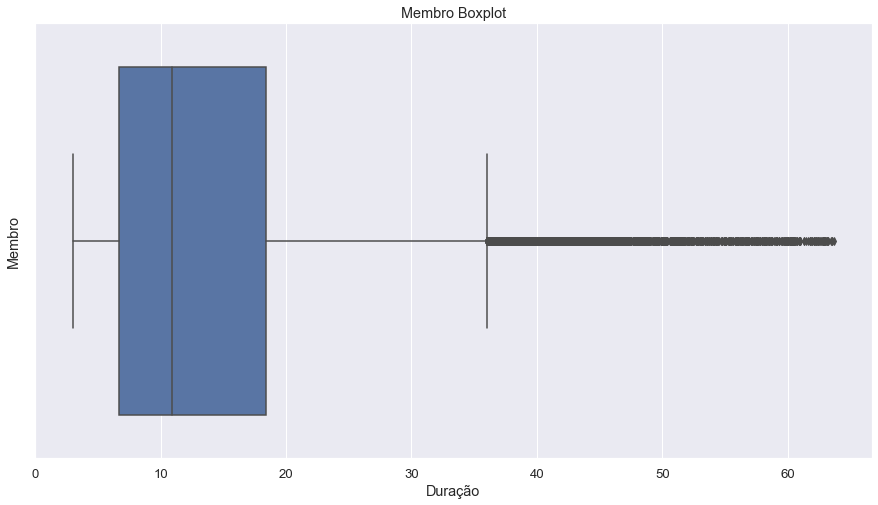

In [48]:
sns.set_theme(style="white", palette="pastel")
sns.set(font_scale = 1.2)
sns.boxplot((data.query("Usuário == 'membro'")['Duração']/60)).set(title='Membro Boxplot', xlabel='Duração', ylabel='Membro')
plt.gcf().set_size_inches(15, 8)

In [29]:
(data.query("Usuário == 'membro'")['Duração']/60).describe()

count    53044.00
mean        14.11
std         10.09
min          3.00
25%          6.70
50%         10.95
75%         18.42
max         63.65
Name: Duração, dtype: float64

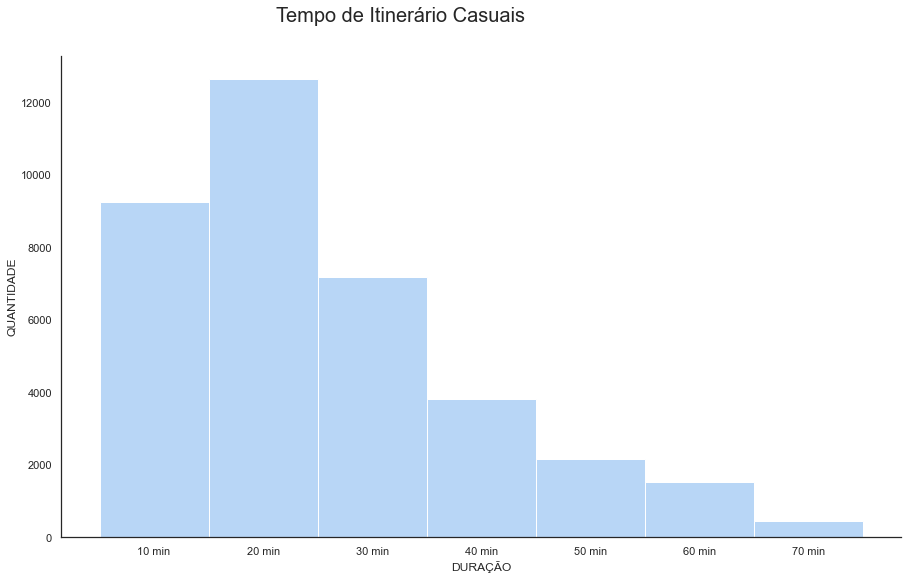

In [47]:
sns.set_theme(style="white", palette="pastel")
label = ['10 min','20 min', '30 min', '40 min', '50 min', '60 min', '70 min']
ax =sns.displot(pd.cut(data.query("Usuário == 'casual'")['Duração'], bins=np.arange(0, 4201, 600), labels=label));
ax.fig.suptitle('Tempo de Itinerário Casuais', fontsize=20, y=1.05);
ax.set(xlabel='DURAÇÃO', ylabel='QUANTIDADE')
plt.gcf().set_size_inches(15, 8)

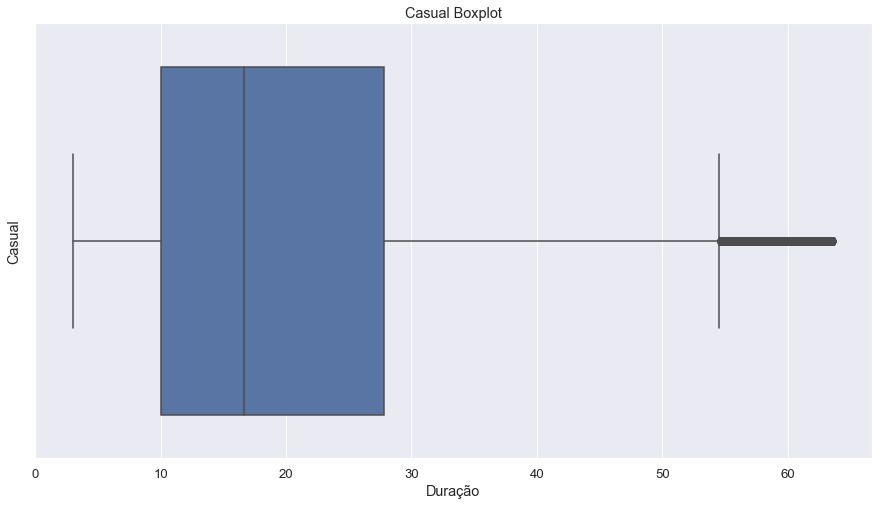

In [31]:
sns.set(font_scale = 1.2)
sns.boxplot((data.query("Usuário == 'casual'")['Duração']/60)).set(title='Casual Boxplot', xlabel='Duração', ylabel='Casual')
plt.gcf().set_size_inches(15, 8)

In [32]:
(data.query("Usuário == 'casual'")['Duração']/60).describe()

count    36992.00
mean        20.63
std         13.83
min          3.00
25%         10.00
50%         16.67
75%         27.80
max         63.65
Name: Duração, dtype: float64

---

* Diante dos gráficos e das análises estatísticas que seguem cada um deles. Podemos notar que a média de duração dos itinerários para o dois tipos de usuário são diferentes: os membros usam em média durante **14 min**, e os casuais durante **20min**.
* A distruibuição pelos boxplot também apresenta diferenças significantes: os `membros` tem a Amplitude Interquartil localizada entre **6 e 18 min**, já os `casuais` entre **10 e 27 min**.

---

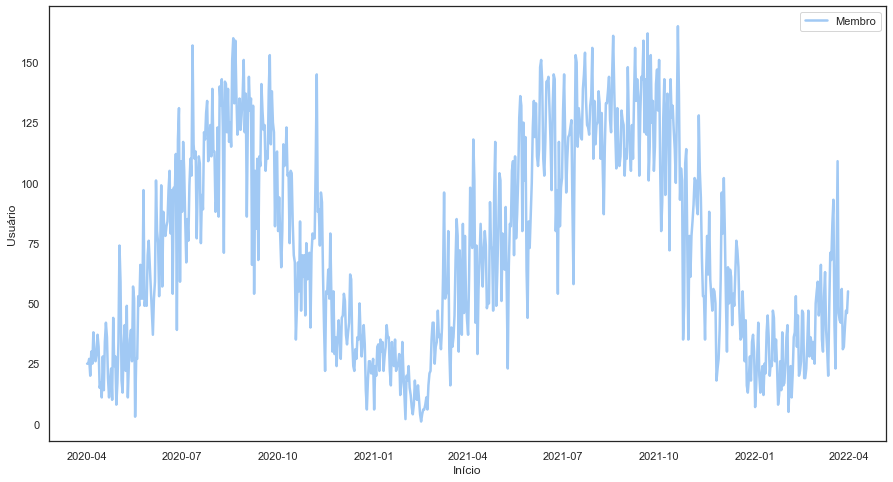

In [49]:
sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=data.query("Usuário == 'membro'").groupby('Início')['Usuário'].count(),  linewidth=2.5, label='Membro')
ax.fig.suptitle('Sazonalidade Membros', fontsize=20, y=1.05)
plt.gcf().set_size_inches(15, 8)

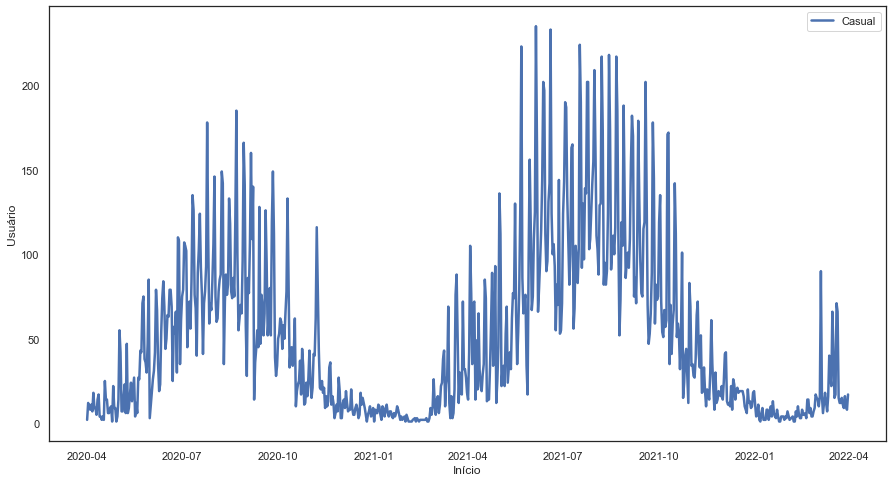

In [50]:
sns.set_theme(style="white")
sns.lineplot(data=data.query("Usuário == 'casual'").groupby('Início')['Usuário'].count(),  linewidth=2.5, label='Casual')
plt.gcf().set_size_inches(15, 8)

___

* Acima possuimos a distribuição do tempo separada para os dois valores em análise pela variável `Usuário`. Pode-se notar a **Sazonalidade** presente nos dados representada principalmente pela estações do ano, tendo os meses de **Verão** como principal expoente. Também é possível perceber a variação dos dias, visto que os `Membros` são mais regulares no uso das bicicletas.
* É possível notar também que durante o período de pandemia, houve um aumento considerável de usuários `Casuais`na estação Verão e isso não se transformou em novos `Membros`.

In [35]:
membro = pd.DataFrame(data.query("Usuário == 'membro'")[['Embarque', 'Long', 'Lat']].value_counts().nlargest(10)).reset_index()
casual = pd.DataFrame(data.query("Usuário == 'casual'")[['Embarque', 'Long', 'Lat']].value_counts().nlargest(10)).reset_index()
inCommon = membro[membro['Embarque'].isin(casual['Embarque'])]
inCommon.columns = ['Nome Estação', 'Long', 'Lat', 'Contagem']
membro.columns = ['Nome Estação', 'Long', 'Lat', 'Contagem']
casual.columns = ['Nome Estação', 'Long', 'Lat', 'Contagem']

In [36]:
def generateBasemap(default_location=[41.8781, -87.6298], default_zoom_start=13):
    basemap = folium.Map(location=default_location,zoom_start=default_zoom_start)
    return basemap

In [37]:
basemap = generateBasemap()

Mapa dos 10 pontos de embarques mais populares para os membros:

In [38]:
HeatMap(membro[[ 'Lat','Long', 'Contagem']], zoom=20).add_to(basemap)
basemap

Mapa dos 10 pontos de embarques mais populares para os casuais:

In [39]:
HeatMap(casual[[ 'Lat','Long', 'Contagem']], zoom=20).add_to(basemap)
basemap

---

* Os mapas acima demonstram os 10 lugares mais populares de `Embarque` para os Usuários. É possível notar semelhanças e diferenças entre os lugares adotados pelos `Usuários`.

---

---

# Considerações Finais

---


* As medidas de conversão de usuários casuais para membros pode ser adotada focando nos finais de semana.
* Estações do ano como o Inverno merece investigação mais profunda no sentido da lucratividade da operação, visto que apresenta grande disparidade em relação as outras estações e menor número de usuários casuais para captação de novos membros.
* É  possível notar que a duração dos itinerários casuais é maior que a dos membros. Isso possibilitaria a adesão de campanhas explicativas de como seria mais vantajoso a adesão dos planos de adesão contínua nos postos de embarques mais frequentados.
* No período em análise é possível notar que no Verão de 2021 houve um aumento nítido de popularidade que não se converteu em adesão. É preciso investigar mais a fundo as razões desse aumento. É possível supôr que que esse período corresponda as normas de restrições à Covid-19, caso em que muitos lugares adotaram o trabalho remoto e isso possibilitou um aumento populacional ocioso.

In [40]:
data.to_excel('trip_data.xlsx')